# Tutorial: Neural Network from Scratch

Last updated: Mar 27, 2024

### Define Neural Network Architecture

Initialize the parameters for a two-layer network: one hidden layer and one output layer.

The network follows the notation from here: 

**Parameters:**
- input_size: The number of input features. For our dataset, this is 2 (x and y coordinates).
- hidden_size: The number of neurons in the hidden layer. This is a hyperparameter that can be adjusted
                based on the complexity of the model and the task.
- output_size: The number of neurons in the output layer. For our dataset, this is 3 (three classes)
                
**Returns:**
- params: A dictionary containing the parameters `W1`, `b1`, `W2`, `b2` initialized as follows:
    - `W1`: Weight matrix for the input to hidden layer. It has a shape of (hidden_size x input_size).
            Initialized with small random values (using a normal distribution) to break symmetry and ensure
            that learning can proceed. Multiplying by 0.01 keeps the weights small, which is often beneficial
            for learning.
    - `b1`: Bias vector for the hidden layer. It has a shape of (hidden_size x 1). Initialized to zeros,
            which is a common practice. Even though initializing biases to zero is relatively safe, the
            important part is breaking symmetry in the weights. 
    - `W2`: Weight matrix for the hidden to output layer. It has a shape of (output_size x hidden_size),
            similar to `W1` but adapted to the output size. Also initialized with small random values.
    - `b2`: Bias vector for the output layer. It has a shape of (output_size x 1), initialized to zeros.

$$ W = {\begin{bmatrix}
    w_{11} & ... & w_{1m}\\
    \vdots & \ddots & \vdots \\
    w_{n1} & ... & w_{nm}
\end{bmatrix}}_{\text{ }n\times m}\;\;\; A_{l-1} = {\begin{bmatrix}
    a_{(l-1)1} \\
    \vdots\\
    a_{(l-1)m}
\end{bmatrix}}_{\text{ }m\times 1} \;\;\; b ={\begin{bmatrix}
    b_{l1}  \\
    \vdots  \\
    b_{ln}
\end{bmatrix}}_{\text{ }n\times 1}\;\;\;
Z ={\begin{bmatrix}
    z_{l1}  \\
    \vdots  \\
    z_{ln}
\end{bmatrix}}_{\text{ }n\times 1}\tag{1}$$

Here, for batch (Vanilla) gradient descent, $A_{l-1}$ now is an $m\times N$ matrix and $Z_l$ is an $n\times N$ matrix. $N$ is the number of samples.   


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to initialize network parameters
def initialize_parameters(input_size, hidden_size, output_size):
    
    # np.random.seed(42)  # Sets the seed for random number generation for reproducibility
    
    # Initialize weights and biases
    params = {
        "W1": np.random.randn(hidden_size, input_size) * 0.01,  # Small random weights for W1
        "b1": np.zeros((hidden_size, 1)),  # Zeros for biases in the hidden layer
        "W2": np.random.randn(output_size, hidden_size) * 0.01,  # Small random weights for W2
        "b2": np.zeros((output_size, 1))   # Zeros for biases in the output layer
    }
    return params  # Return the initialized parameters

### Activation function

| **Name**    | **Equation** | **Derivative** |
| -------- | ------- | ------- |
| Identity  |$f(x) = x$ |$f'(x) = 1$ |
| Logistic (sigmoid) |$f(x) = \frac{1}{1 + e^{-x}}$  |$f(x) = f(x)(1-f(x))$ |
| ReLu    |$f(x) = \begin{cases} 0 & \text{for } x < 0 \\ x & \text{for } x \geq 0 \end{cases}$  |$f(x) = \begin{cases} 0 & \text{for } x < 0 \\ 1 & \text{for } x \geq 0 \end{cases}$  |

In [2]:
# Sigmoid activation function
def sigmoid(x, path='forward'):

    if path == 'forward':
        y = 1 / (1 + np.exp(-x))
    elif path == 'backward':
        sig = 1 / (1 + np.exp(-x))
        y = sig * (1 - sig)
    return y

# softmax    
def softmax(x):
# https://wandb.ai/krishamehta/softmax/reports/How-to-Implement-the-Softmax-Function-in-Python--VmlldzoxOTUwNTc

    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)


In [3]:
# Forward propagation
def forward_propagation(X, params):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1, 'forward')  # Hidden layer activation
    
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)  # Output layer activation
    
    cache = (Z1, A1, Z2, A2)
    return A2, cache

In [4]:
# Backward propagation to compute gradients
def backward_propagation(params, cache, X, Y):
    N = X.shape[1]
    W1, W2 = params['W1'], params['W2']
    Z1, A1, Z2, A2 = cache
    
    dZ2 = A2 - Y # please review the tutorial document (Backpropagating Cross-Entropy Loss)

    dW2 = np.dot(dZ2, A1.T) / N
    db2 = np.sum(dZ2, axis=1, keepdims=True) / N # sum of colums in dZ2
    dA1 = np.dot(W2.T, dZ2)

    dZ1 = dA1 * sigmoid(Z1, path='backward')
    dW1 = np.dot(dZ1, X.T) / N
    db1 = np.sum(dZ1, axis=1, keepdims=True) / N
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

In [5]:
# Compute the cross-entropy cost
def compute_cost(A2, Y):
    m = Y.shape[1]  # Number of examples
    # Compute the cross-entropy cost
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A2+ 1e-10))) #+ 1e-10 is to avoid numerical overflow. 
    cost = np.squeeze(cost)  # Ensures cost is the dimension we expect.
    return cost


Gradient Descent

$ \theta_{j+1} \leftarrow \theta_{j} - \alpha \frac{\partial}{\partial \theta_{j}} J(\theta) $


In [6]:
# Update parameters using gradient descent
def update_parameters(params, grads, learning_rate=1.2):
    params["W1"] -= learning_rate * grads["dW1"]
    params["b1"] -= learning_rate * grads["db1"]
    params["W2"] -= learning_rate * grads["dW2"]
    params["b2"] -= learning_rate * grads["db2"]
    
    return params

### Data Generation

In [7]:
# Function to generate circular dataset
def generate_circle_data(inRadius=2, midRadius=(2.5, 4), outRadius=(4.5, 6), numPt=200):
    # Inner circle
    set1 = np.zeros((numPt, 2))
    count = 0
    while count < numPt:
        xin = np.random.uniform(-inRadius, inRadius)
        yin = np.random.uniform(-inRadius, inRadius)
        if xin**2 + yin**2 < inRadius**2:
            set1[count, :] = [xin, yin]
            count += 1
    
    # Middle ring
    set2 = np.zeros((numPt, 2))
    count = 0
    while count < numPt:
        xin = np.random.uniform(-midRadius[1], midRadius[1])
        yin = np.random.uniform(-midRadius[1], midRadius[1])
        if midRadius[1]**2 > xin**2 + yin**2 > midRadius[0]**2:
            set2[count, :] = [xin, yin]
            count += 1

    # Outer ring
    set3 = np.zeros((numPt, 2))
    count = 0
    while count < numPt:
        xin = np.random.uniform(-outRadius[1], outRadius[1])
        yin = np.random.uniform(-outRadius[1], outRadius[1])
        if outRadius[1]**2 > xin**2 + yin**2 > outRadius[0]**2:
            set3[count, :] = [xin, yin]
            count += 1

    return set1, set2, set3


Cost after iteration 0: 1.098644
Cost after iteration 1000: 0.196773
Cost after iteration 2000: 0.069784
Cost after iteration 3000: 0.041195
Cost after iteration 4000: 0.029713
Cost after iteration 5000: 0.023235
Cost after iteration 6000: 0.019010
Cost after iteration 7000: 0.016046
Cost after iteration 8000: 0.013865
Cost after iteration 9000: 0.012203


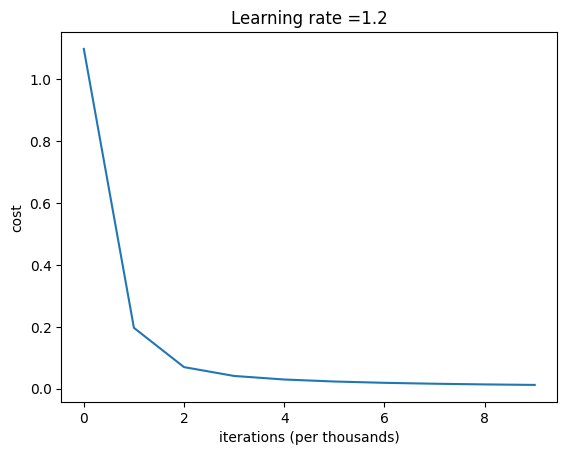

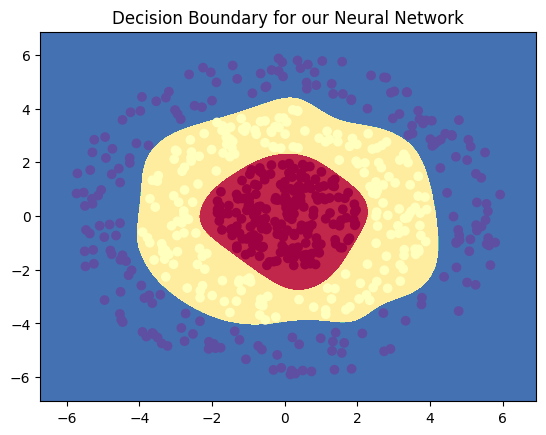

In [8]:
# Generate dataset
set1, set2, set3 = generate_circle_data()

# Data preparation

# Concatenate all point sets
X = np.concatenate((set1, set2, set3)).T  # Input features

# Generate labels: 0 for inner circle, 1 for middle ring, 2 for outer ring
Y = np.array([0] * len(set1) + [1] * len(set2) + [2] * len(set3))  # Labels for each class

# Convert labels to one-hot encoding
Y = np.eye(3)[Y].T  # 3 for three classes

# Initialize parameters
params = initialize_parameters(2, 10, 3)  # Input layer: 2 neurons, Hidden layer: 10 neurons, Output layer: 2 neurons

# Train the neural network
num_iterations = 10000
costs = []  # Keep track of cost

for i in range(0, num_iterations):
    A2, cache = forward_propagation(X, params)
    cost = compute_cost(A2, Y)
    grads = backward_propagation(params, cache, X, Y)
    params = update_parameters(params, grads)
    
    if i % 1000 == 0:
        print("Cost after iteration %i: %f" % (i, cost))
        costs.append(cost)

# Plotting the cost over iterations
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per thousands)')
plt.title("Learning rate =" + str(1.2))
plt.show()

# Function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()].T, params)
    Z = np.argmax(Z, axis=0)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=np.argmax(y, axis=0), cmap=plt.cm.Spectral)

# Function for the neural network prediction
def model(X, params):
    A2, _ = forward_propagation(X, params)
    return A2

# Plotting the decision boundary
plot_decision_boundary(model, X, Y)
plt.title("Decision Boundary for our Neural Network")
plt.show()